In [1]:
import os
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../../../ukb-dementia-shap/")

from logic.data_processing.data_import import dataload
from logic.data_processing.data_processing import data_proc_main
from logic.analysis.analysis import AnalysisCharts
from logic.ml.classification_shap import IDEARs_funcs
from ukb_utils.utils import basic_funcs


import pandas as pd
import numpy as np

ac=dataload()
dp=data_proc_main()
ml=IDEARs_funcs()
an=AnalysisCharts()

In [2]:
df_dem=pd.read_parquet(ml.path+'df_dem_final.parquet')#df_pd_20210924
df_dem=ml.pre_process_1(df=df_dem,agemin=55,agemax=70,depvar='dementia',apoe=2)
mask=(df_dem['APOE4_Carriers']>0)
df_dem['APOE4_Status']=0
df_dem.loc[mask,'APOE4_Status']=1

<Figure size 2000x3000 with 0 Axes>

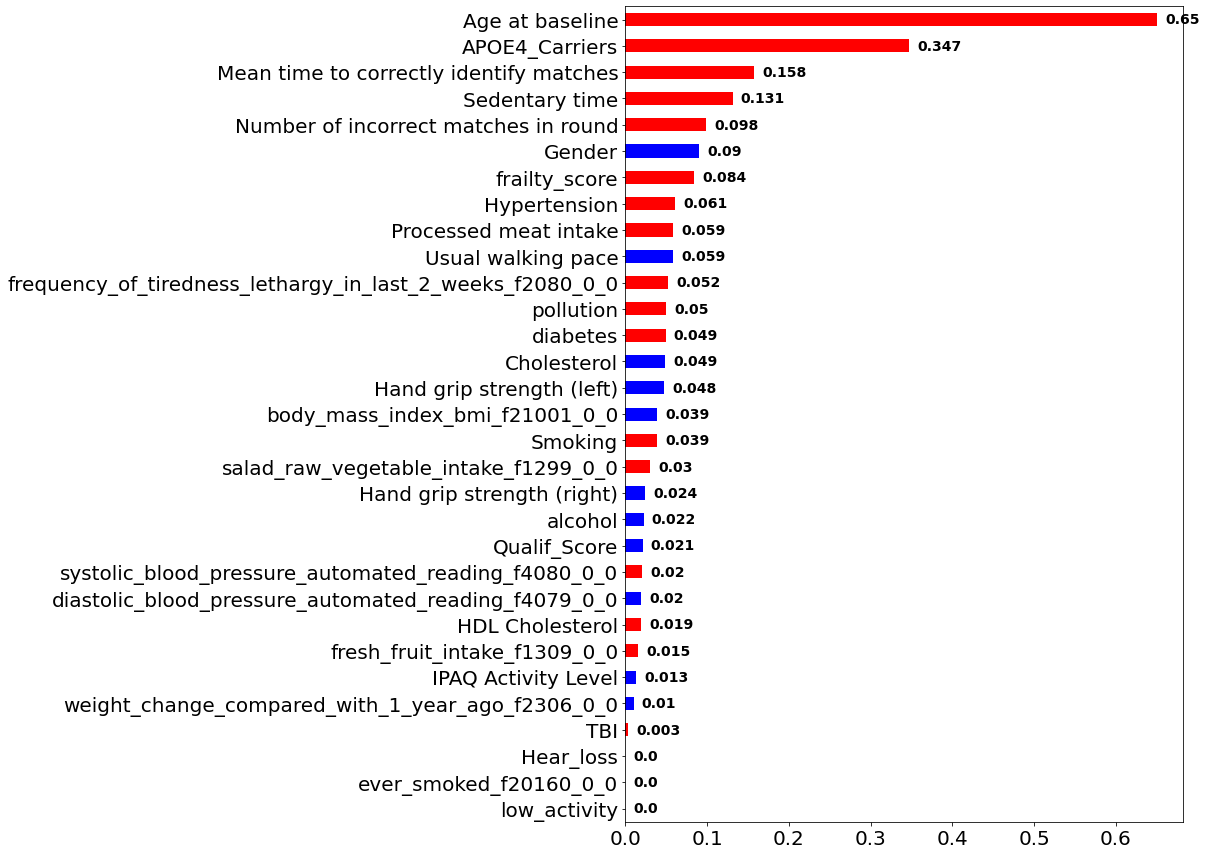

In [18]:
shap_tuple_all_study=pd.read_pickle(dp.path+'shap_tuple_all_study.pkl')
feats_study=ml.shapgraphs_tuple(shap_tuple_all_study,max_disp=35,figname='shap_chart_for_dem_test',plot=True)

#### Get the slope values for top 35 SHAP scores for APOE4 and non

In [19]:
dic_map_inv=dict(zip([ml.variablemap[m] for m in ml.variablemap],[m for m in ml.variablemap]))

feats=pd.read_csv(ml.path_dem+'/data/shap_features.csv')
feats.sort_values(by='SHAP_abs',ascending=False,inplace=True)
feats=feats.head(35)

feats['var2']=feats['Variable'].map(dic_map_inv)
feats.loc[pd.isnull(feats['var2']),'var2']=feats['Variable']

feats_study['var2']=feats_study['Variable'].map(dic_map_inv)
feats_study.loc[pd.isnull(feats_study['var2']),'var2']=feats_study['Variable']

featlist=list(set([v for v in feats['var2'].head(35)]+[v for v in feats_study['var2'].head(35)]))

#### Putting together the features for scatter chart

In [30]:
%%time
varlist=[]
slope_diffs=[]
apoe_slopes=[]
non_apoe_slopes=[]
pvals=[]
for v in featlist:
    
    df_dem.loc[df_dem[v]==np.inf,v]=np.nan
    
    try:
        slope_diff,slope1,slope2,p_value=\
an.pvalue_slopes(df=df_dem.loc[pd.notnull(df_dem[v]),],var=v,depvar='dementia',splitvar='APOE4_Status',splitval=0,val_comp=1,return_all=True)
    except:
        slope_diff,slope1,slope2,p_value=0,0,0
        
        print(v,'error')
        
    varlist.append(v)
    apoe_slopes.append(slope1)
    non_apoe_slopes.append(slope2)
    slope_diffs.append(slope_diff)
    pvals.append(p_value)
    
    print(v,'done')
    

df1=pd.concat([feats_study,feats.head(35)],axis=0)
shap_dict=dict(df1.groupby('Variable')['Sign'].max())

df_apoe4_split=pd.DataFrame({'Variable':varlist,'APOE4_slope':apoe_slopes,'Non_APOE4_slope':non_apoe_slopes,'Slope_diff':slope_diffs,
             'pvalues':pvals})
df_apoe4_split['Variable2']=df_apoe4_split['Variable'].map(ml.variablemap)
df_apoe4_split.loc[pd.isnull(df_apoe4_split['Variable2']),'Variable2']=df_apoe4_split['Variable']
df_apoe4_split['Sign']=df_apoe4_split['Variable2'].map(shap_dict)
df_apoe4_split.to_csv(ml.path_dem+'/data/'+'df_apoe4_split.csv')

nan
nan
Slope Difference: nan
low_activity done
-3.1685496303295677
0.0007660079485027733
Slope Difference: 7.516326675944777
weight_change_compared_with_1_year_ago_f2306_0_0 done
11.307809859386568
6.002435995445156e-30
Slope Difference: 3.1852373604551625
avg_duration_to_first_press_of_snapbutton_in_each_round done
-7.57726306868273
1.76460358839965e-14
Slope Difference: 3.622729872856419
perc_correct_matches_rounds done
2.492437700987361
0.006343479246294322
Slope Difference: 1.796089462050371
frequency_of_tiredness_lethargy_in_last_2_weeks_f2080_0_0 done
4.741241601333117
1.0620622331672488e-06
Slope Difference: 4.472477273119908
systolic_blood_pressure_automated_reading_f4080_0_0 done
0.013587406575036015
0.49457957582102646
Slope Difference: 1.009950315115448
creactive_protein_f30710_0_0 done
-4.787851230105352
8.428826840371692e-07
Slope Difference: 1.9789593286008502
usual_walking_pace_f924_0_0 done
10.678976963354613
6.383541474701137e-27
Slope Difference: 2.3265278265079634
n

ValueError: All arrays must be of the same length

#### Running slopes for individual variables - fig 3 

In [3]:
slopes_dic=dict({'age_when_attended_assessment_centre_f21003_0_0':['Age when attending assessment centre',1,0,1],
 'Total ICD10 Conditions at baseline':['Number of conditions at baseline',0,0,0.95],
 'longstanding_illness_disability_or_infirmity_f2188_0_0':['Number of longstanding illnesses',0,0,1],
 'perc_correct_matches_rounds':['Percentage rounds with correct matches (quintile)',0,1,1],
'average_total_household_income_before_tax_f738_0_0':['Average household income before tax (£K)',0,0,1],
'number_of_treatmentsmedications_taken_f137_0_0':['Number of treatments/medications taken',0,0,0.95],
 'AST_ALT_ratio':['AST:ALT ratio (quintile)',0,1,1],
 'Retired':['Retired (Y=1, N=0)',0,0,1],
 'overall_health_rating_f2178_0_0':['Self-reported health rating score 0 (Poor) - 3 (Very Good)',0,0,1],
 'pollution':['Combined Pollution (quintile)',0,1,1],
 'sedentary_time':['Sedentary time (quintile)',0,1,1],
 'alcohol':['Alcohol intake',0,0,1]})

In [4]:
vars_trans=[
 'Total ICD10 Conditions at baseline', 
 'perc_correct_matches_rounds',
 'average_total_household_income_before_tax_f738_0_0',
 'number_of_treatmentsmedications_taken_f137_0_0',
 'AST_ALT_ratio',
 'overall_health_rating_f2178_0_0',
 'pollution',
 'sedentary_time',
 'alcohol']

In [5]:
vars_use=[v for v in slopes_dic]+['sex_f31_0_0','APOE4_Status','dementia']

df_dem_use=df_dem[vars_use]
df_dem_use[df_dem_use==np.inf]=np.nan
df_dem_use=an.age_gend_norm_mult(df_dem_use,vars_trans,normvars=['age_when_attended_assessment_centre_f21003_0_0'])
#df_dem_use=an.std_scale(df_dem_use,vars_trans)

age_when_attended_assessment_centre_f21003_0_0
22.08266518272115
2.3195368605408313e-108
Slope Difference: 3.8724790681075683
[<matplotlib.lines.Line2D object at 0x7fad7b4d31f0>, <matplotlib.lines.Line2D object at 0x7fad7b4d07f0>]


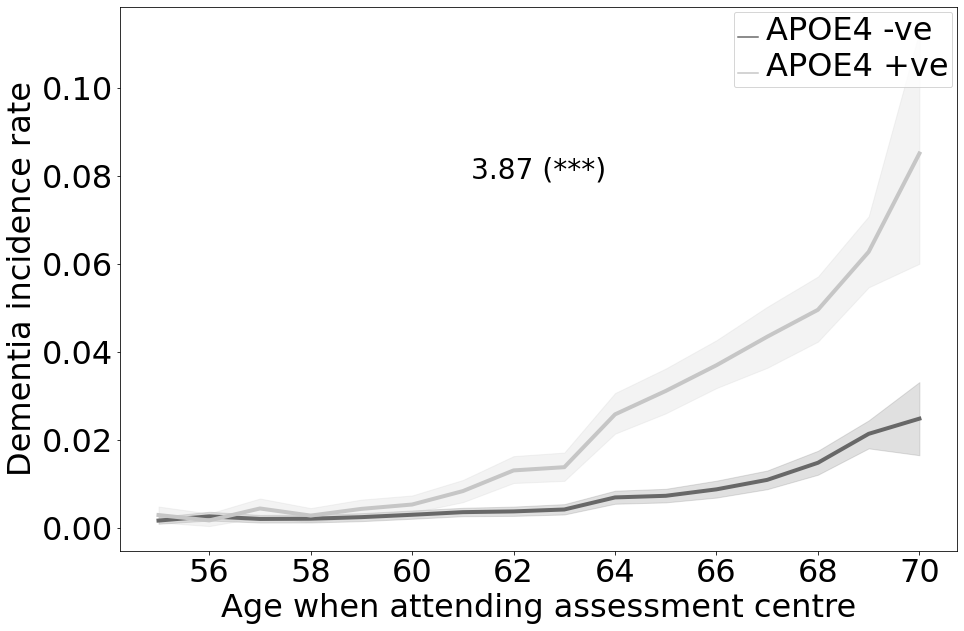

Total ICD10 Conditions at baseline
11.50783248590068
6.023410089856333e-31
Slope Difference: 2.4289083430089944
[<matplotlib.lines.Line2D object at 0x7fad8c547160>, <matplotlib.lines.Line2D object at 0x7fad8c5474f0>]


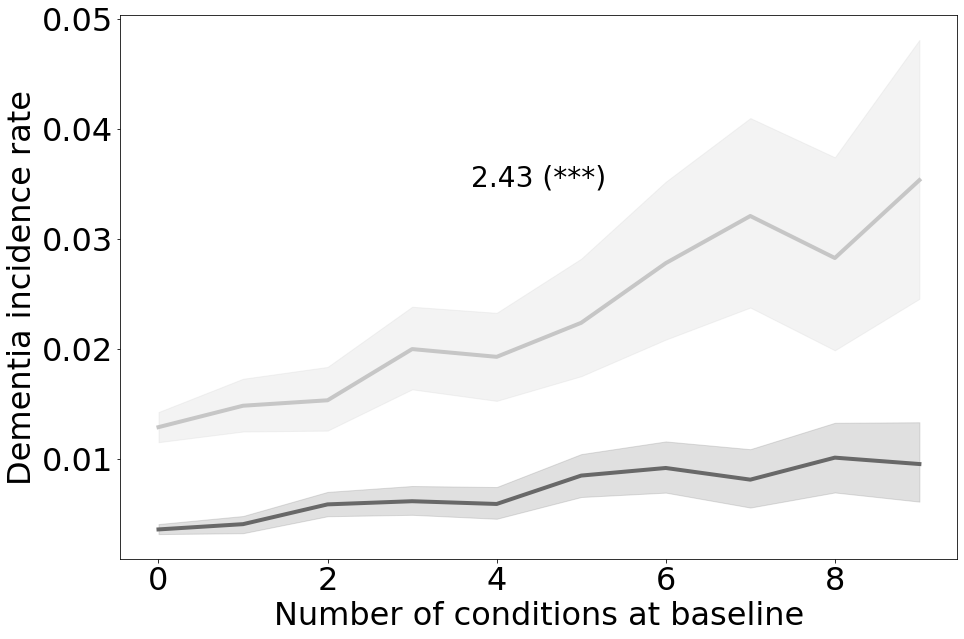

longstanding_illness_disability_or_infirmity_f2188_0_0
8.018771708553489
5.340390109233029e-16
Slope Difference: 2.242709535715127
[<matplotlib.lines.Line2D object at 0x7fad8f1bcd90>, <matplotlib.lines.Line2D object at 0x7fad8f1d8640>]


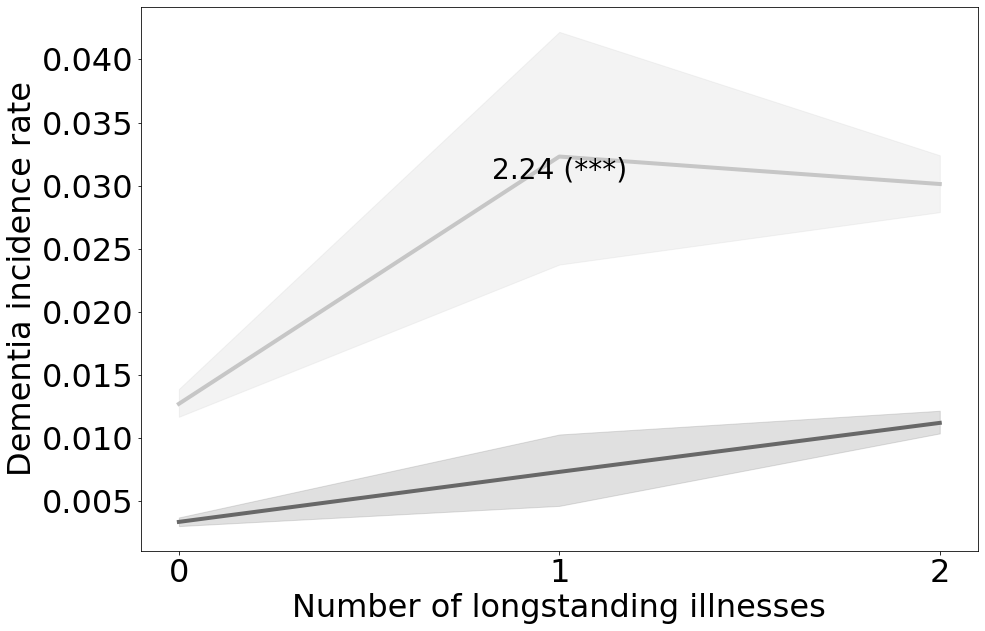

perc_correct_matches_rounds
-7.57726306868273
1.76460358839965e-14
Slope Difference: 3.622729872856419
[<matplotlib.lines.Line2D object at 0x7fad912ac070>, <matplotlib.lines.Line2D object at 0x7fad91287280>]


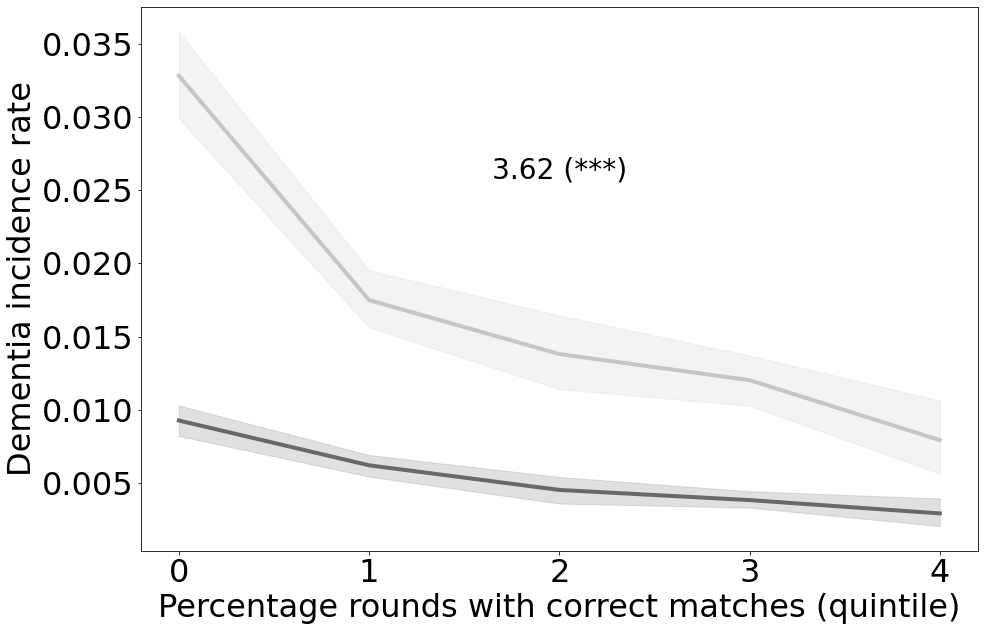

average_total_household_income_before_tax_f738_0_0
-8.026176463288472
5.027877506051027e-16
Slope Difference: 3.0983362296272032
[<matplotlib.lines.Line2D object at 0x7fad7b562340>, <matplotlib.lines.Line2D object at 0x7fad7b561220>]


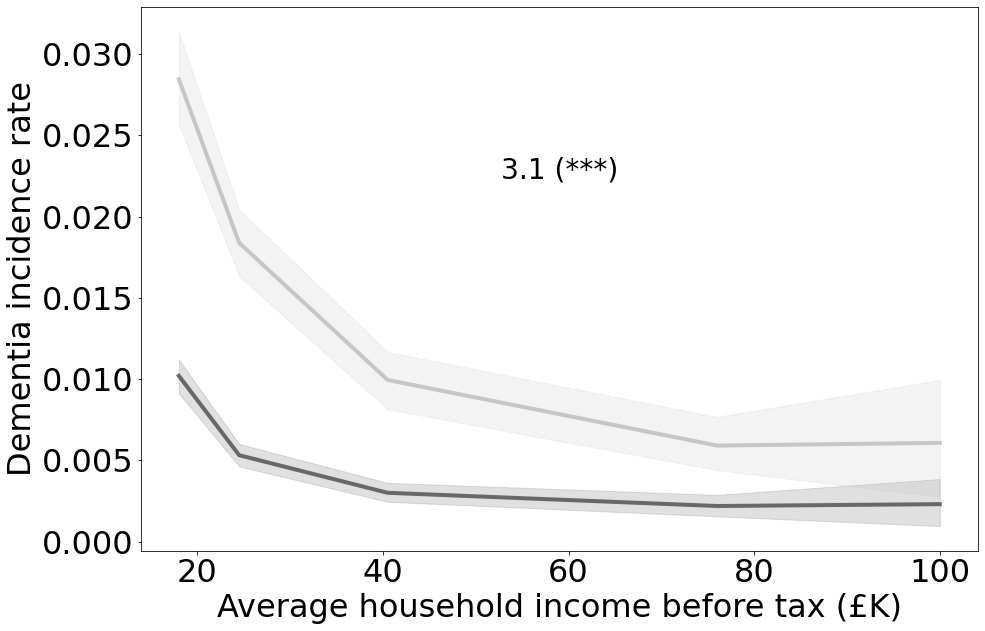

number_of_treatmentsmedications_taken_f137_0_0
10.678976963354613
6.383541474701137e-27
Slope Difference: 2.3265278265079634
[<matplotlib.lines.Line2D object at 0x7fad936a2df0>, <matplotlib.lines.Line2D object at 0x7fad9367a1c0>]


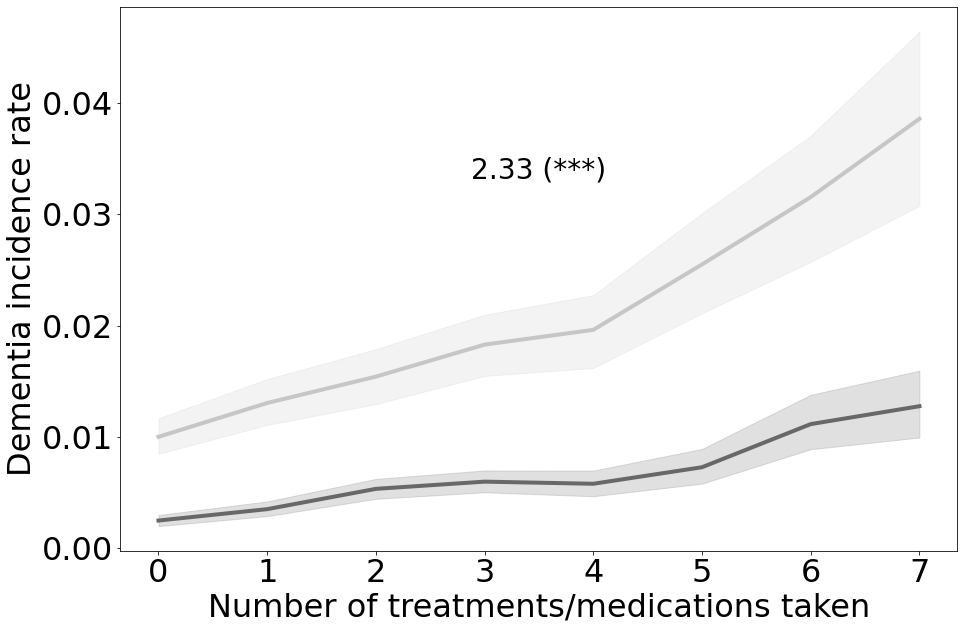

AST_ALT_ratio
7.278288211359803
1.6904123081763625e-13
Slope Difference: 5.159884600203418
[<matplotlib.lines.Line2D object at 0x7fad9b558910>, <matplotlib.lines.Line2D object at 0x7fad9b558580>]


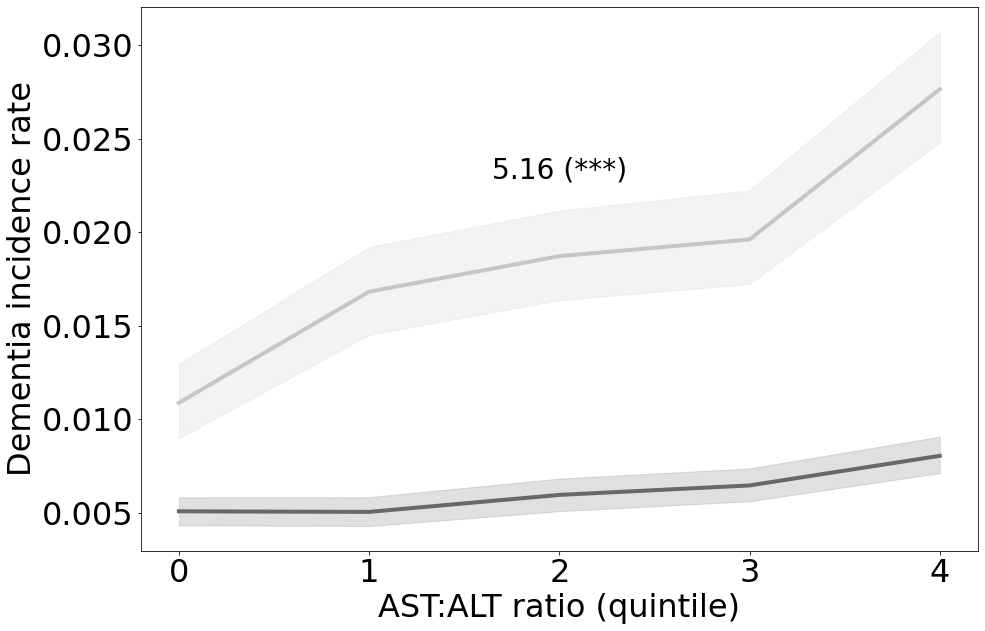

Retired
12.35937951737495
2.1674488166702816e-35
Slope Difference: 3.6893533179540254
[<matplotlib.lines.Line2D object at 0x7fad58fec1c0>, <matplotlib.lines.Line2D object at 0x7fad5901dd30>]


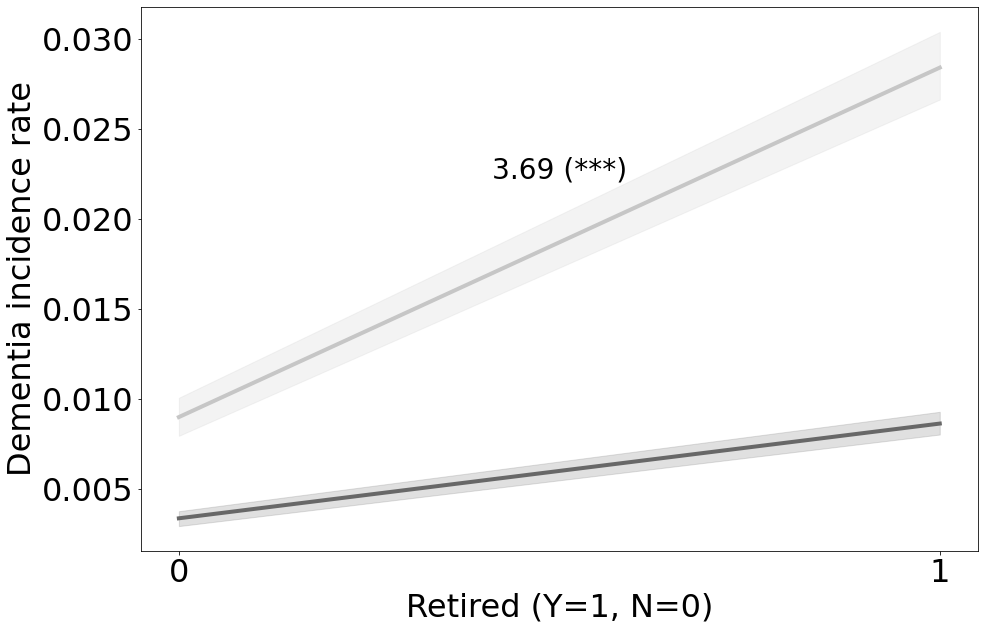

overall_health_rating_f2178_0_0
-7.089644344968372
6.722854719125403e-13
Slope Difference: 2.0702306408221394
[<matplotlib.lines.Line2D object at 0x7fad70aadc10>, <matplotlib.lines.Line2D object at 0x7fad70aadfa0>]


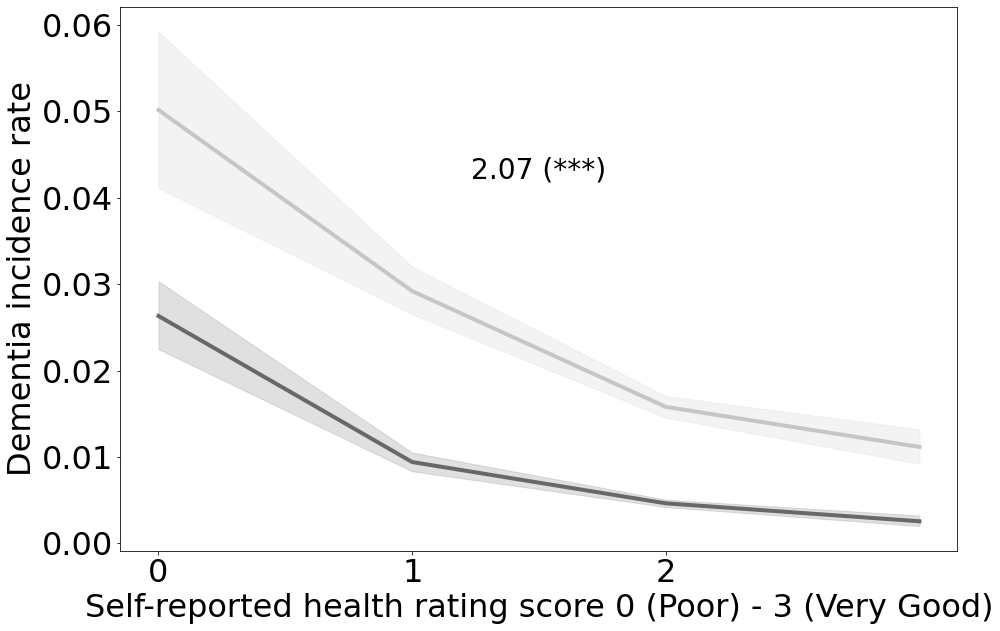

pollution
3.4807492462608107
0.0002500066808095718
Slope Difference: 3.0726119734423745
[<matplotlib.lines.Line2D object at 0x7fad58ffd130>, <matplotlib.lines.Line2D object at 0x7fad70ac3130>]


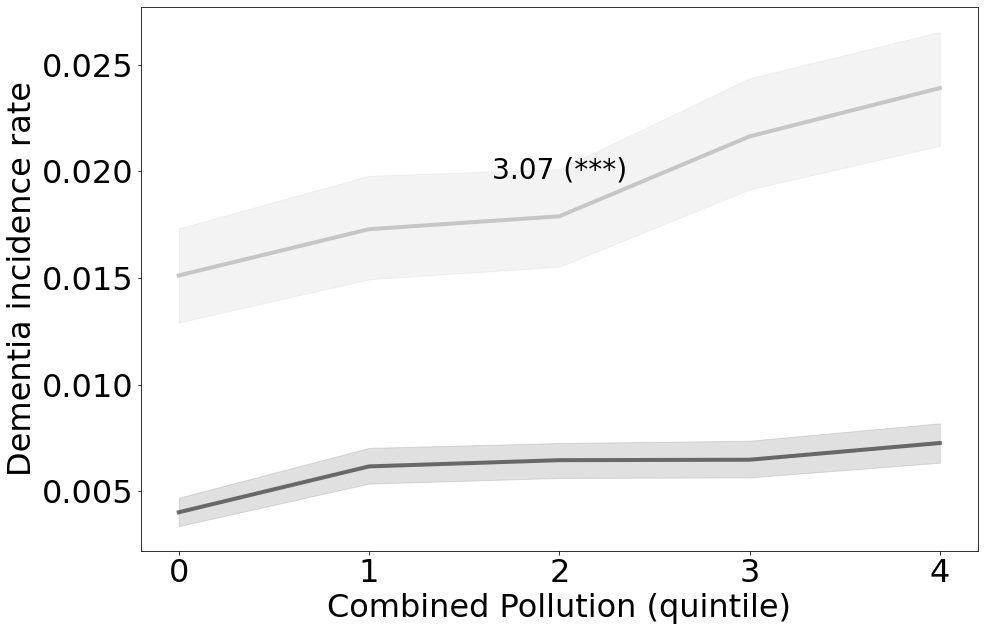

sedentary_time
3.831023609615174
6.380562917279742e-05
Slope Difference: 2.0518098206299795
[<matplotlib.lines.Line2D object at 0x7fad8b71f250>, <matplotlib.lines.Line2D object at 0x7fad8b71f910>]


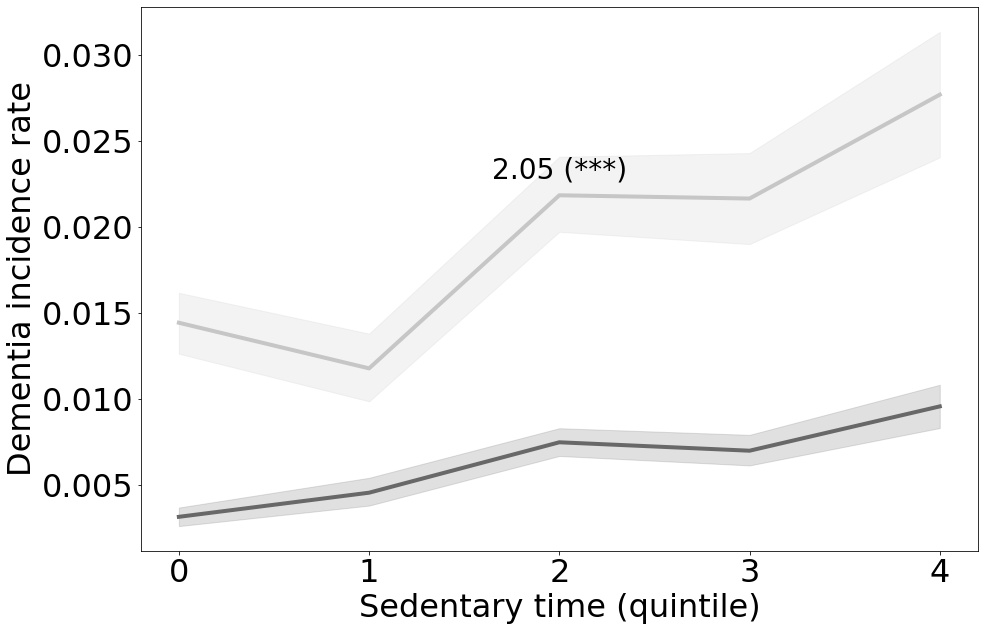

alcohol
-4.891413878072146
5.005709881050753e-07
Slope Difference: 3.3636196677349632
[<matplotlib.lines.Line2D object at 0x7fad8f60eac0>, <matplotlib.lines.Line2D object at 0x7fad7b4d02e0>]


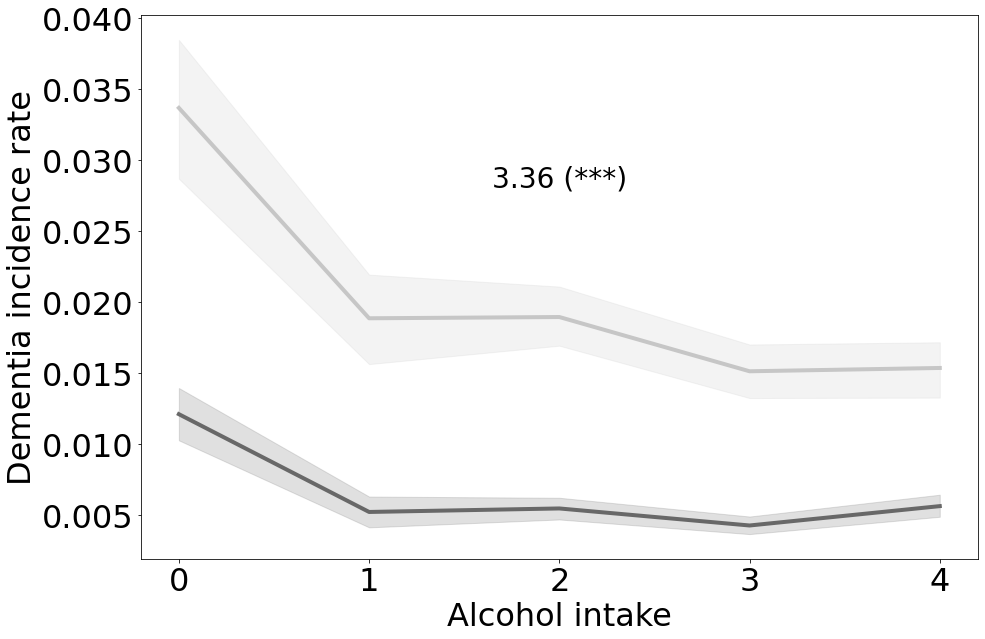

In [57]:
df_allvars=pd.DataFrame([])
for s in slopes_dic:
    print(s)
    df_sum=an.calc_rr(df=df_dem,var=s,slicevar='APOE4_Status',splitval=0,depvar='dementia',
		xlabel=slopes_dic[s][0],ylabel='Dementia incidence rate',leg=slopes_dic[s][1],quint=slopes_dic[s][2],val_comp=1,
               quant=slopes_dic[s][3],
          vcomp='ART',pic_ext='.jpg')
    df_sum['Variable']=slopes_dic[s][0]
    df_allvars=pd.concat([df_allvars,df_sum],axis=0)
    

#### Split of retirement by age

13.270645068958155
1.713093195339337e-40
Slope Difference: 2.470594321302308
[<matplotlib.lines.Line2D object at 0x7fad7043d370>, <matplotlib.lines.Line2D object at 0x7fad7043d700>]


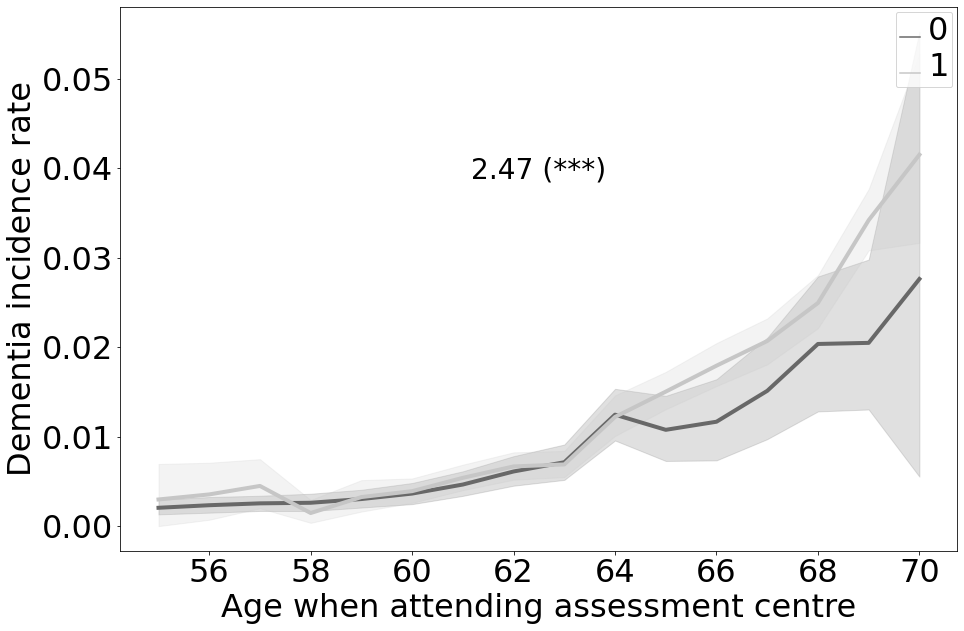

In [5]:
s='age_when_attended_assessment_centre_f21003_0_0'
df_sum=an.calc_rr(df=df_dem,var=s,slicevar='Retired',splitval=0,depvar='dementia',
		xlabel=slopes_dic[s][0],ylabel='Dementia incidence rate',leg=slopes_dic[s][1],quint=slopes_dic[s][2],val_comp=1,
               quant=slopes_dic[s][3],
          vcomp='ART',pic_ext='.jpg')

In [58]:
df_allvars.to_csv(ml.path_figures_dem+'supp_mat_slopes.csv')

In [38]:
dp.findcols(df_dem,'pollution')

['nitrogen_dioxide_air_pollution_2010_f24003_0_0',
 'nitrogen_oxides_air_pollution_2010_f24004_0_0',
 'particulate_matter_air_pollution_pm10_2010_f24005_0_0',
 'particulate_matter_air_pollution_pm25_2010_f24006_0_0',
 'particulate_matter_air_pollution_pm25_absorbance_2010_f24007_0_0',
 'particulate_matter_air_pollution_2510um_2010_f24008_0_0',
 'nitrogen_dioxide_air_pollution_2005_f24016_0_0',
 'nitrogen_dioxide_air_pollution_2006_f24017_0_0',
 'nitrogen_dioxide_air_pollution_2007_f24018_0_0',
 'particulate_matter_air_pollution_pm10_2007_f24019_0_0',
 'average_daytime_sound_level_of_noise_pollution_f24020_0_0',
 'average_evening_sound_level_of_noise_pollution_f24021_0_0',
 'average_nighttime_sound_level_of_noise_pollution_f24022_0_0',
 'average_16hour_sound_level_of_noise_pollution_f24023_0_0',
 'average_24hour_sound_level_of_noise_pollution_f24024_0_0',
 'pollution']